In [32]:
import torch
import numpy as np
from IPython.core.debugger import set_trace
import imageio
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from torch.autograd import Variable
import torch.nn.functional as F


import importlib.util


from tkmodel.TwoCUM import TwoCUMfittingConc
from tkmodel.TwoCUM import TwoCUM

In [33]:
'''
Questions for 03/11/2021
Is my data generation okay, im worried what kind of random distribution i should use.
Should i normalise Fp to between 0 and 1 like the others?
Possibly add uncertainty to replicate the test data set a bit more?
'''

'\nQuestions for 03/11/2021\nIs my data generation okay, im worried what kind of random distribution i should use.\nShould i normalise Fp to between 0 and 1 like the others?\nPossibly add uncertainty to replicate the test data set a bit more?\n'

In [127]:
#useful functions

def plot_PK(output, true):
    AIF_plot = np.load("data/AIF.npy")
    t_plot = np.arange(0,366,2.45)
    fitted_curve = TwoCUM(output, t_plot, AIF_plot, 0)
    plt.plot(t_plot, fitted_curve, label = 'Prediction')
    fitted_curve = TwoCUM(true, t_plot, AIF_plot, 0)
    plt.plot(t_plot, fitted_curve, label = 'True')
    plt.legend()
    plt.show()
    
def generate_xy(num_curves):
    AIF = np.load("data/AIF.npy")
    data_size = AIF.shape[0]
    t = np.arange(0,366,2.45)

    E = np.random.rand(1,num_curves) #0 to 1 for both E and vp
    vp = np.random.rand(1,num_curves)
    Fp = 1e-5*np.random.rand(1,num_curves)
    
#     Fp = abs(np.random.normal(size=num_curves, loc= 1e-5, scale = 1e-4)[None,:])

    E_Fp = np.concatenate((E, Fp), axis =0)
    y = np.concatenate((E_Fp, vp), axis =0)


    x = np.zeros((num_curves, data_size))
    for i in range(num_curves):
        x[i] = TwoCUM(y[:,i], t, AIF, 0)

    y = y.T 
    
    return x,y

def training_loop(x, y, epochs, plot = True):
    #x is the inputs, y is the true value of the predictions
    optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
#     loss_func = torch.nn.MSELoss()

    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).float()
    inputs = Variable(x)
    outputs = Variable(y)
    torch_dataset = Data.TensorDataset(x, y) #wrapper to join x and y into one dataloader

    dataloader = Data.DataLoader(torch_dataset, batch_size=50, shuffle=True) #dataloader for batching and shuffle every epoch

    enum = epochs
    loss_list = []
    for epoch in range(enum):
        
        for i, (mini_x, mini_y) in enumerate(dataloader): # take out a batch for each step
            
            
            
            mini_x = Variable(mini_x)
            mini_y = Variable(mini_y)

            prediction = net(mini_x)     # input x and predict based on x
            loss = loss_fn_batch(prediction, mini_y)
            
                
            optimizer.zero_grad()   # clear gradients so it doesn't stack up over the loops
            loss.backward()        # backprop
            print(loss.grad)
            optimizer.step() 
            
        loss_list.append(loss.detach().numpy())
        print(epoch, loss)
        if epoch%10 == 0 and plot == True:
            #plot one example of prediction vs true values
            print('Prediction, True Values')
            print(prediction[0].detach().numpy() , mini_y[0].detach().numpy())
            plot_PK(prediction[0].detach().numpy(), mini_y[0].detach().numpy())
    
    #plot the loss over epochs
    plt.plot(list(range(enum)), loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


In [128]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(150, 200)   # hidden layer
        self.hidden2 = torch.nn.Linear(200, 100)   # hidden layer
        self.hidden3 = torch.nn.Linear(100, 50)
        self.hidden4 = torch.nn.Linear(50, 300)
        self.hidden5 = torch.nn.Linear(300, 200)
        self.predict = torch.nn.Linear(200, 3)

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = F.relu(self.hidden4(x))
        x = F.relu(self.hidden5(x))
        x = self.predict(x)             # linear output
        return x
    
#example custom loss function
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,y_pred, y_true):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss
    
print(Net())

Net(
  (hidden): Linear(in_features=150, out_features=200, bias=True)
  (hidden2): Linear(in_features=200, out_features=100, bias=True)
  (hidden3): Linear(in_features=100, out_features=50, bias=True)
  (hidden4): Linear(in_features=50, out_features=300, bias=True)
  (hidden5): Linear(in_features=300, out_features=200, bias=True)
  (predict): Linear(in_features=200, out_features=3, bias=True)
)


In [129]:
#maybe functions
def loss_fn(outputs, targets):
    #E, Fp, vp
    #time spacings
    t = np.arange(0,366,2.45)
    AIF = torch.from_numpy(np.load("data/AIF.npy"))

    
    #For outputs
    #First calculate the parameter Tp
    E, Fp ,vp = outputs[0], outputs[1], outputs[2]
    Tp=(vp/Fp)*(1-E)
    #Calculate the IRF
    exptTp= torch.exp(-1*t/Tp) #adding dummy variables so it divides properly
    R=exptTp*(1-E) + E

    #Calculate the convolution
    AIF1 = AIF.view(1, 1, -1)
    R = torch.flip(R, (0,)).view(1, 1, -1)
    temp = t[1]*torch.nn.functional.conv1d(AIF1, R, padding = AIF.shape[0]-1).view(-1)
    F_out = Fp*temp[0:len(t)]
    
    #For targets - copy pasted
    E, Fp ,vp = targets[0], targets[1], targets[2]
    Tp=(vp/Fp)*(1-E)
    #Calculate the IRF
    exptTp= torch.exp(-1*t/Tp)
    R=exptTp*(1-E) + E
    #Calculate the convolution
    AIF1 = AIF.view(1, 1, -1)
    R = torch.flip(R, (0,)).view(1, 1, -1)
    temp = t[1]*torch.nn.functional.conv1d(AIF1, R, padding = AIF.shape[0]-1).view(-1)
    F_targets = Fp*temp[0:len(t)]

    return torch.sum((F_out - F_targets)**2)/F_out.shape[0]

def loss_fn_batch(outputs, targets):
    #E, Fp, vp
    #time spacings
    t = np.arange(0,366,2.45)
    t = torch.tensor(t)
    
    batch_size = outputs[:,0].shape[0]
    AIF = torch.from_numpy(np.load("data/AIF.npy"))
    AIF1 = AIF.view(1, 1, -1) #reshaped for convolution

    
    #For outputs
    #First calculate the parameter Tp
    E, Fp ,vp = outputs[:,0], outputs[:,1], outputs[:,2]
    Tp=(vp/Fp)*(1-E)
    #Calculate the IRF
    exptTp= torch.exp(-1*t[:,None]/Tp[None,:]) #adding dummy variables so it divides properly

    R=exptTp*(1-E) + E

    #Calculate the convolution
    R = torch.flip(R, (0,)).T #Reshape to fit the the convolution
    R = torch.unsqueeze(R, 1)
    temp = t[1]*torch.nn.functional.conv1d(AIF1, R, padding = AIF.shape[0]-1).view(batch_size, -1)
    F_out = Fp.unsqueeze(-1)*temp[:,0:len(t)] #unsqueeze to match dimensions
    
    #For targets - copy pasted
    E_true, Fp_true ,vp_true = targets[:,0], targets[:,1], targets[:,2]
    Tp_true=(vp_true/Fp_true)*(1-E_true)
    #Calculate the IRF
    exptTp_true= torch.exp(-1*t[:,None]/Tp_true[None,:]) #adding dummy variables so it divides properly

    R_true=exptTp_true*(1-E_true) + E_true

    #Calculate the convolution
    R_true = torch.flip(R_true, (0,)).T #Reshape to fit the the convolution
    R_true = torch.unsqueeze(R_true, 1)
    temp_true = t[1]*torch.nn.functional.conv1d(AIF1, R_true, padding = AIF.shape[0]-1).view(batch_size, -1)
    F_targets = Fp_true.unsqueeze(-1)*temp_true[:,0:len(t)] #unsqueeze to match dimensions
    
    return torch.sum((F_out - F_targets)**2)/F_out.shape[1]


outputs, targets = torch.Tensor([[0.5, 2e-4, 0.5],[0.4, 2e-5, 0.3]]), torch.Tensor([[0.2, 2.5e-5, 0.5],[0.1, 6e-5, 0.3]])
outputs1, targets1 = torch.Tensor([0.5, 2e-4, 0.5]), torch.Tensor([0.2, 2.5e-5, 0.5])
outputs2, targets2 = torch.Tensor([0.4, 2e-5, 0.3]), torch.Tensor([0.1, 6e-5, 0.3])

loss1 = loss_fn(outputs1, targets1)
loss2 = loss_fn(outputs2, targets2)

print('Batch')
loss = loss_fn_batch(outputs, targets)
print('batch = 2',loss, loss.shape)
print('batch = 1',loss1, loss1.shape)
print('batch = 1 second',loss2, loss2.shape)




# outputs1, targets1 = outputs.detach().numpy(), targets.detach().numpy()
# plot_PK(outputs, targets)

Batch
batch = 2 tensor(0.0039, dtype=torch.float64) torch.Size([])
batch = 1 tensor(0.0037, dtype=torch.float64) torch.Size([])
batch = 1 second tensor(0.0002, dtype=torch.float64) torch.Size([])


/var/folders/2m/v5d7mznx1v39h5mv6nwjnvxm0000gn/T/ipykernel_13202/479595454.py:66: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  print(loss.grad)


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


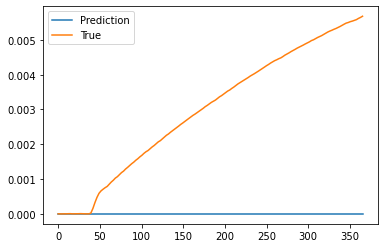

/var/folders/2m/v5d7mznx1v39h5mv6nwjnvxm0000gn/T/ipykernel_13202/479595454.py:66: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  print(loss.grad)


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
8 tensor(nan, dtype=torch.float64, grad_fn=<DivBackward0>)
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
N

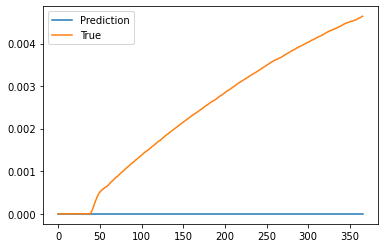

/var/folders/2m/v5d7mznx1v39h5mv6nwjnvxm0000gn/T/ipykernel_13202/479595454.py:66: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  print(loss.grad)


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


KeyboardInterrupt: 

In [130]:
x, y = generate_xy(10000)
net = Net()

training_loop(x ,y ,epochs=100)